In [14]:
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc

In [2]:
path = "../processed/train/evaluated/paraphrase_humarin_samples_62_EVALUATED_27_11_23.csv"
df = pd.read_csv(path)

In [3]:
z_threshold = 4.0
# Need to binary classify the results 

In [22]:
def gen_base_df(full_df):
    base_wmark_df = full_df[["kgw-watermarked", "kgw-wm-zscore"]].copy()
    base_wmark_df["watermarked"] = [True for _ in range(len(base_wmark_df))]
    base_wmark_df = base_wmark_df.rename(columns={"kgw-watermarked": "text", "kgw-wm-zscore": "z-score"})

    non_wmark_df = full_df[["non-watermarked", "non-wm-zscore"]].copy()
    non_wmark_df["watermarked"] = [False for _ in range(len(non_wmark_df))]
    non_wmark_df = non_wmark_df.rename(columns={"non-watermarked": "text", "non-wm-zscore": "z-score"})
    
    bc_df = pd.concat([base_wmark_df, non_wmark_df])
    bc_df['watermark-detected'] = bc_df.apply(lambda x: x['z-score'] > z_threshold, axis=1)
    return bc_df

In [4]:
def gen_paraphrase_df(full_df, pp_iter = 1, z_threshold = 4.0):
    wmark_df = full_df[[f"pp-kgw-{pp_iter}", f"kgw-wm-pp-zscore-{pp_iter}"]]
    wmark_df = wmark_df.rename(columns={f"pp-kgw-{pp_iter}": "text", f"kgw-wm-pp-zscore-{pp_iter}": "z-score"})
    wmark_df["watermarked"] = [True for _ in range(len(wmark_df))]
    
    nwmark_df = full_df[[f"pp-unwatermarked-{pp_iter}", f"non-wm-pp-zscore-{pp_iter}"]]
    nwmark_df = nwmark_df.rename(columns={f"pp-unwatermarked-{pp_iter}": "text", f"non-wm-pp-zscore-{pp_iter}": "z-score"})
    nwmark_df["watermarked"] = [False for _ in range(len(nwmark_df))]
    
    bc_df = pd.concat([wmark_df, nwmark_df])
    bc_df["watermark-detected"] = bc_df.apply(lambda x: x['z-score'] > z_threshold, axis=1)
    return bc_df

In [5]:
image_output_path = "../results/images/roc_curve/"

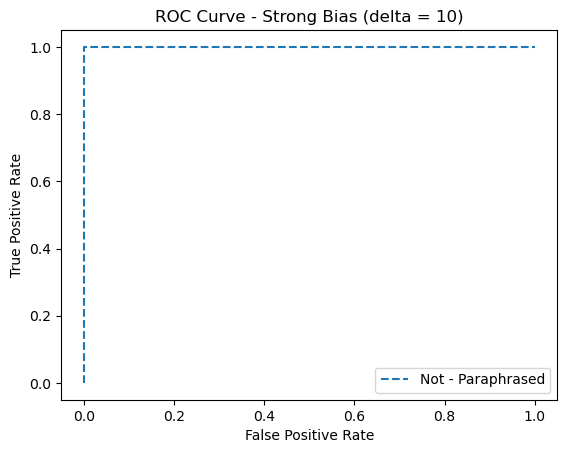

In [26]:
base_df = gen_base_df(df)
y_values, y_pred = base_df["watermarked"], base_df["watermark-detected"]
fpr, tpr, _ = roc_curve(y_values, y_pred)
plt.plot(fpr, tpr, linestyle='--', label=f'Not - Paraphrased')

plt.title("ROC Curve - Strong Bias (delta = 10)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

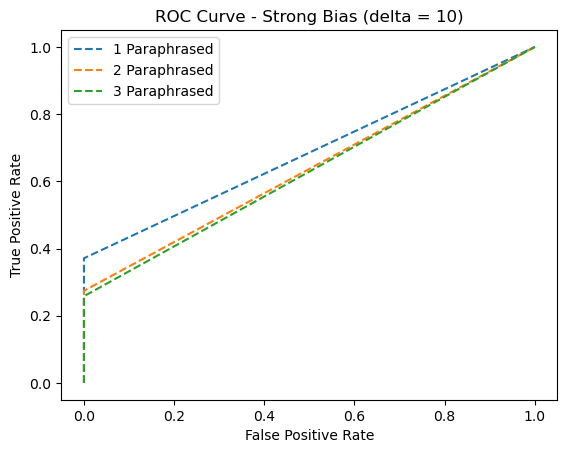

In [27]:
for i in range(1,4):
    pp_bc_df = gen_paraphrase_df(df, pp_iter=i)
    y_values, y_pred = pp_bc_df["watermarked"], pp_bc_df["watermark-detected"]
    fpr, tpr, _ = roc_curve(y_values, y_pred)
    plt.plot(fpr, tpr, linestyle='--', label=f'{i} Paraphrased')

plt.title("ROC Curve - Strong Bias (delta = 10)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(image_output_path+f"kgw-paraphased-gpt2.p")
plt.show()